# Set directory path

In [ ]:
!rm -rf ~/.kaggle/kaggle.json # Remove the directory if it exists
!mkdir -p ~/.kaggle # This should create a directory named kaggle.json
!touch ~/.kaggle/kaggle.json  # Creates an empty file called kaggle.json


# Now place your credentials from kaggle.json into the file created in the previous step.
!cp kaggle.json ~/.kaggle/kaggle.json # Copy contents to the file
!chmod 600 ~/.kaggle/kaggle.json # Ensure correct permissions

# load Data

In [ ]:
import kagglehub

#!/bin/bash
!kaggle datasets download itsshuvra/gender-classified-dataset-with-masked-face

Dataset URL: https://www.kaggle.com/datasets/itsshuvra/gender-classified-dataset-with-masked-face
License(s): CC-BY-NC-SA-4.0
 98% 1.06G/1.08G [00:10<00:00, 148MB/s]
100% 1.08G/1.08G [00:10<00:00, 110MB/s]


# Unzip data

In [ ]:
import zipfile
with zipfile.ZipFile("gender-classified-dataset-with-masked-face.zip","r") as zip_ref:
    zip_ref.extractall("data")
    zip_ref.close()
    print('done')

done


# libraries import

In [ ]:
import tensorflow
from tensorflow import keras
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.vgg16 import preprocess_input

import matplotlib.pyplot as plt
import numpy as np

# data load using keras

In [ ]:
train_ds=keras.utils.image_dataset_from_directory(
    directory='/content/data/GenderOcclusionData/Training',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True
)
test_ds=keras.utils.image_dataset_from_directory(
    directory='/content/data/GenderOcclusionData/Validation',
    labels="inferred",
    label_mode="int",
    class_names=None,
    color_mode="rgb",
    batch_size=32,
    image_size=(256, 256),
    shuffle=True
)

Found 72318 files belonging to 2 classes.
Found 16813 files belonging to 2 classes.


# check data shape

In [ ]:
for image_batch, labels_batch in train_ds.take(1):
  print(image_batch.shape)
  print(labels_batch.shape)


(32, 256, 256, 3)
(32,)


# visulization

In [ ]:
img=image_batch/255.0

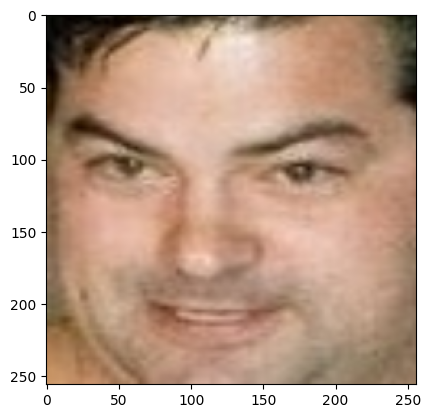

In [ ]:
plt.imshow(img[0])

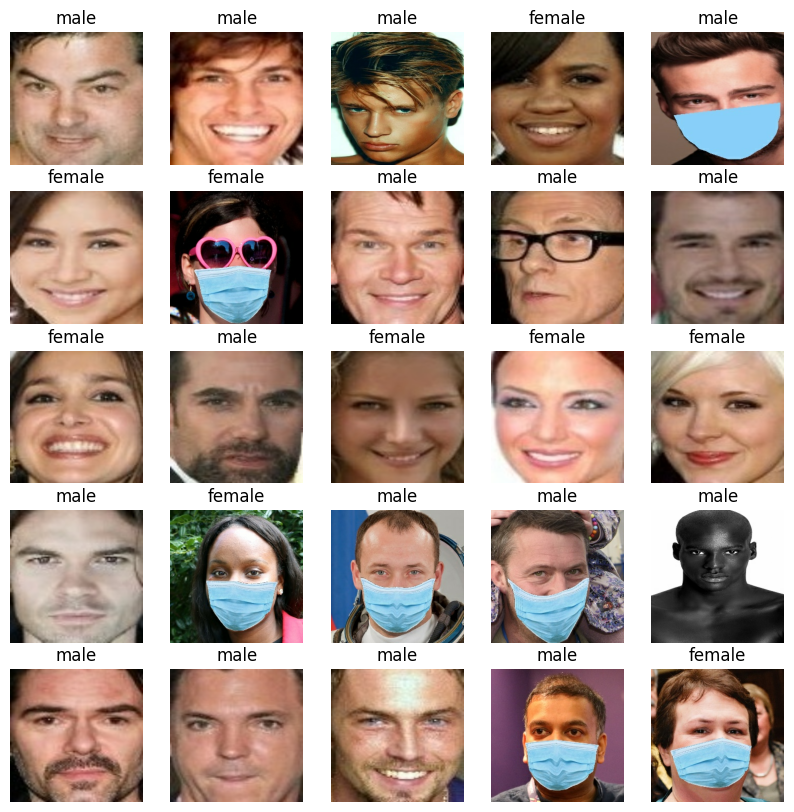

In [ ]:
plt.figure(figsize=(10,10))

for i in range(25):
  plt.subplot(5,5,i+1)
  plt.imshow(img[i])
  plt.title(train_ds.class_names[labels_batch[i]])
  plt.axis('off')

# Data augomentation

In [ ]:
train_gen=ImageDataGenerator(rescale=1./255,
                             shear_range=0.3,
                             zoom_range=0.3,
                             horizontal_flip=True,
                             rotation_range=30,
                             width_shift_range=0.2,
                             height_shift_range=0.2,
                             brightness_range=[0.5,1.5])
test_gen=ImageDataGenerator(rescale=1./255)


In [ ]:
train_genrator=train_gen.flow_from_directory(
    directory='/content/data/GenderOcclusionData/Training',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)
test_genrator=test_gen.flow_from_directory(
    directory='/content/data/GenderOcclusionData/Validation',
    target_size=(256,256),
    batch_size=32,
    class_mode='binary'
)

Found 72318 images belonging to 2 classes.
Found 16813 images belonging to 2 classes.


# data normalize

In [ ]:
import tensorflow as tf
def process(image_batch,labels_batch):
  image=tf.cast(image_batch/255.0,tf.float32)
  return image,labels_batch
  train_genrator=train_genrator.map(process)
  test_genrator=test_genrator.map(process)

# VGG16 model

In [ ]:
conv_base=VGG16(
    weights='imagenet',
    include_top=False,
    input_shape=(256,256,3)
)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
conv_base.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 256, 256, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 256, 256, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 128, 128, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 128, 128, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 128, 128, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 64, 64, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 64, 64, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 64, 64, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 32, 32, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 32, 32, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 32, 32, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 16, 16, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 16, 16, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_pool (MaxPooling2D)           │ (None, 8, 8, 512)           │               0 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

# create FC layers

In [ ]:
model=Sequential()

model.add(conv_base)
model.add(Flatten())

model.add(Dense(200,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(128,activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(1,activation='sigmoid'))

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │       6,553,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200)                 │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,295,657 (81.24 MB)

 Trainable params: 21,295,001 (81.23 MB)

 Non-trainable params: 656 (2.56 KB)

# Freze VGG16 convolution layers

In [ ]:
conv_base.trainable=False

In [ ]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 8, 8, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 32768)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 200)                 │       6,553,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 200)                 │             800 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 200)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          25,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,295,657 (81.24 MB)

 Trainable params: 6,580,313 (25.10 MB)

 Non-trainable params: 14,715,344 (56.13 MB)

# set parametors

In [ ]:
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

# Training vgg16 model

In [ ]:
history=model.fit(train_genrator,epochs=5,validation_data=test_genrator)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 1501s 655ms/step - accuracy: 0.7355 - loss: 0.5588 - val_accuracy: 0.8787 - val_loss: 0.2777
Epoch 2/5
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 1478s 654ms/step - accuracy: 0.8193 - loss: 0.3952 - val_accuracy: 0.8610 - val_loss: 0.3235
Epoch 3/5
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 1416s 627ms/step - accuracy: 0.8253 - loss: 0.3838 - val_accuracy: 0.8839 - val_loss: 0.2763
Epoch 4/5
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 1433s 634ms/step - accuracy: 0.8360 - loss: 0.3695 - val_accuracy: 0.8868 - val_loss: 0.2689
Epoch 5/5
2260/2260 ━━━━━━━━━━━━━━━━━━━━ 1449s 641ms/step - accuracy: 0.8378 - loss: 0.3631 - val_accuracy: 0.9055 - val_loss: 0.2260


# plot accuracy and loss

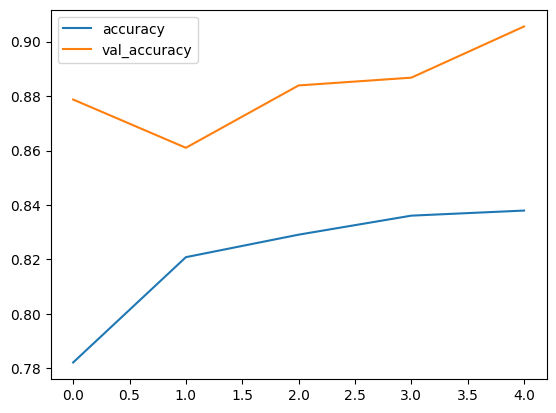

In [ ]:
plt.plot(history.history['accuracy'],label='accuracy')
plt.plot(history.history['val_accuracy'],label='val_accuracy')
plt.legend()

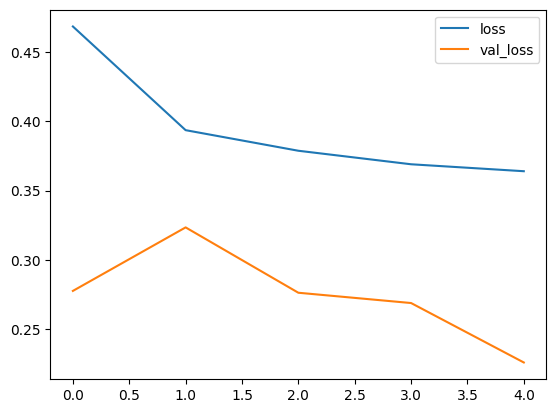

In [ ]:
plt.plot(history.history['loss'],label='loss')
plt.plot(history.history['val_loss'],label='val_loss')
plt.legend()